# Processing: Extracting features from Atari games

The goal of the project is to gather information on frames of a given game (i.e. Breakout).
The processing is composed of the following phases:
- Finding SIFT Keypoints
- Feature matching between frames
- Finding the connected components in the frames
- Classifying the objects we found as stationary or moving
- Track the movement of moving objects.

In [128]:
import os
import numpy as np
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # Set image size in notebook

First let's load frames saved with an interval given out by the step variable.
Then after loading the images we convert them to grayscale return those too.

In [129]:
def load_frames(game, step = 100):
    """"Function that loads frames with a step given in step parameter 
    giving out images in colorscale and grayscale."""
    pth = f"../imgs/{game}"
    images = os.listdir(pth)
    imgs = []
    gray_imgs = []
    
    for i in range(0, len(images), step): # Load all frames in the folder
        image_path = os.path.join(pth, images[i])
        imgs.append(cv.imread(image_path))
        gray_imgs.append(cv.cvtColor(imgs[len(imgs) - 1], cv.COLOR_BGR2GRAY))
    return imgs, gray_imgs

In [130]:
def show_images(imgs, mode = None):
    """"Function to show multiple images in a compact way."""
    n = len(imgs)
    if (n > 5): # Show only first 5 images in list for compactness
        n = 5

    _, ax = plt.subplots(ncols=n, figsize=(50,18))

    for i in range(n):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].grid(False)
        match mode:
            case 'rgb':
                ax[i].imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
            case 'gray':
                ax[i].imshow(imgs[i], cmap='gray')
            case _:
                ax[i].imshow(imgs[i])
        
    plt.tight_layout()

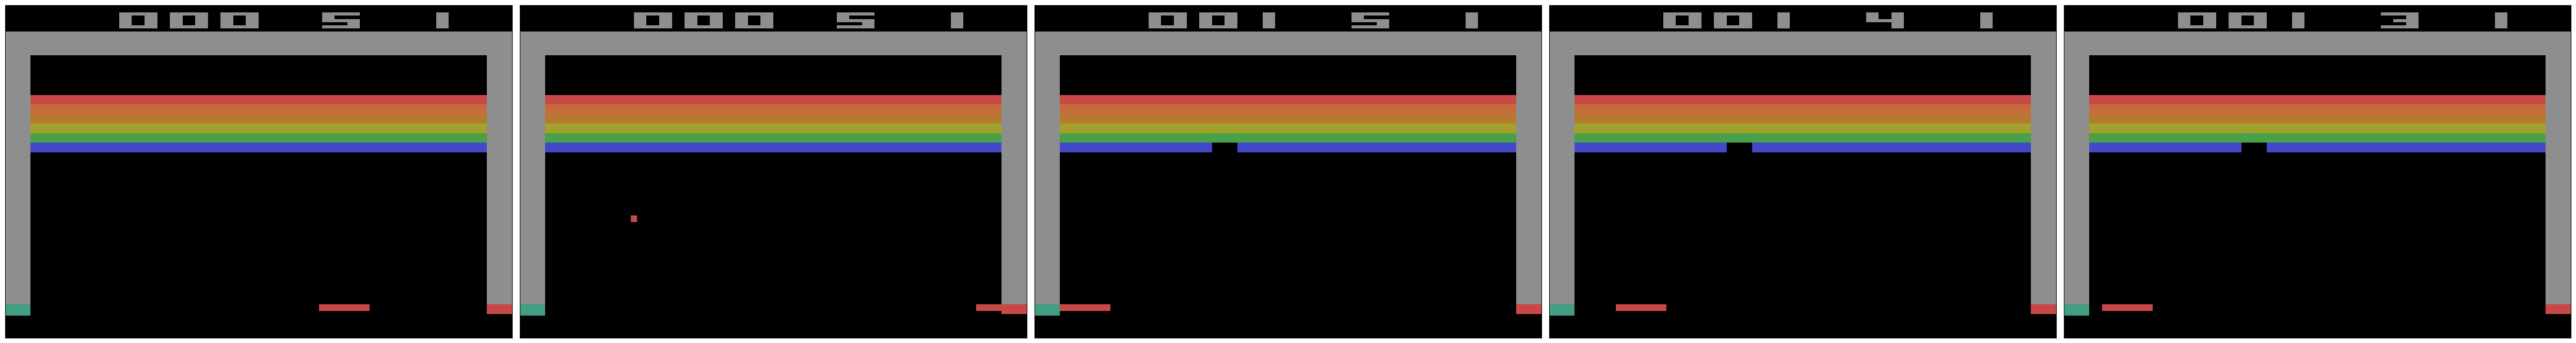

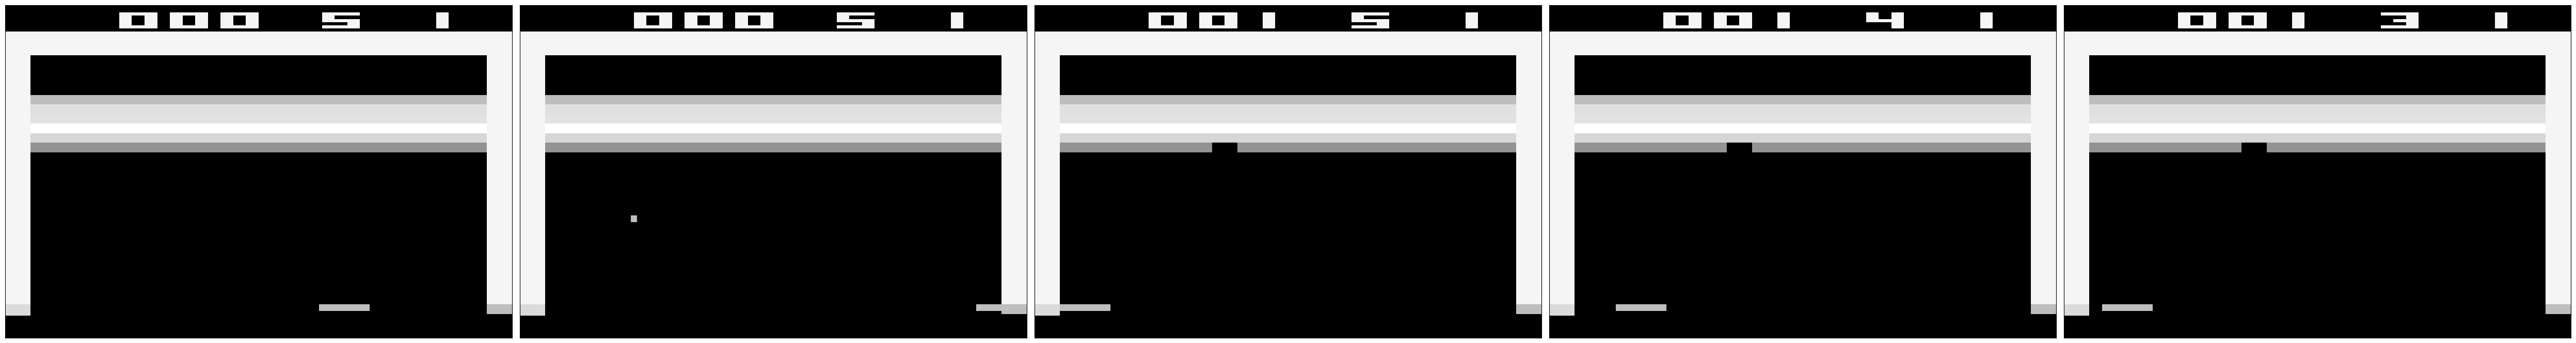

In [131]:
game = 'breakout' # Specify game we want to study
imgs, gray_imgs = load_frames(game, step = 100)

show_images(imgs, mode='rgb')
show_images(gray_imgs, mode='gray')

Now we can start with the proper analisys. The first step is to find keypoints and descriptors.

Conveniently we can just use the openCV module that offers functionality for both finding and matching features given a frame.

In [132]:
# Create a SIFT object
sift = cv.SIFT_create()
kps = [] # List to collect keypoints
des = [] # List to collect descriptors
for g in gray_imgs:
    kp, de = sift.detectAndCompute(g,None)
    kps.append(kp)
    des.append(de)

# Now we can draw the keypoints on the frames themeselves.
kp_imgs = []
for i in range(len(kps)):
    kp_imgs.append(cv.drawKeypoints(gray_imgs[i], kps[i], imgs[i].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

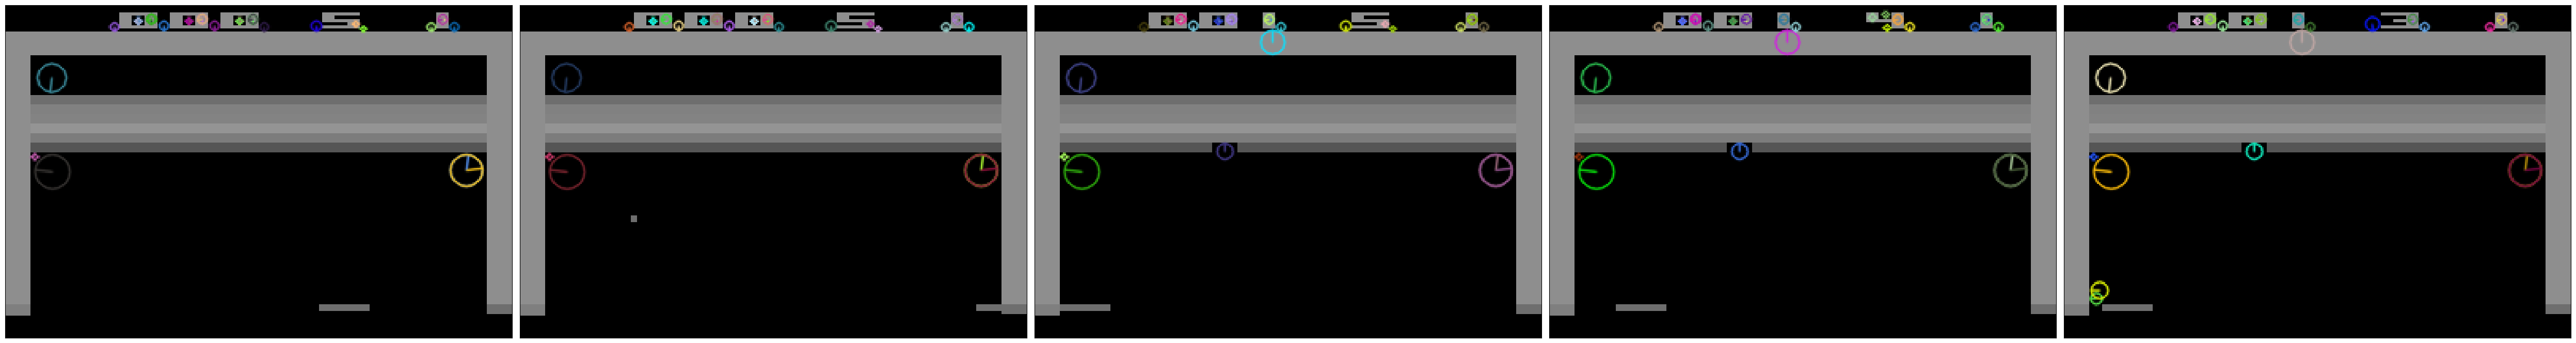

In [133]:
# Now we can visualize the frames with the keypoints
show_images(kp_imgs, mode='rgb')
#plt.imshow(cv.cvtColor(kp_imgs[0], cv.COLOR_BGR2RGB))

Now that we have computed keypoints and descriptors we can find matches between successive frames.

This shows us differences between frames and will be important when dealing with objects later on.

In [134]:
def matchFrames(im1, im2, kp1, kp2, de1, de2, MIN_MATCH_COUNT = 10):
    """"Function to find matches between two successive frames"""
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(de1, de2, k = 2)
    
    # Store all the good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 1, 2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 1, 2)
    
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
    
        h,w = im1.shape
        pts = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1],[w - 1, 0] ]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
    
        im2 = cv.polylines(im2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor = (0,255,0), # Draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # Draw only inliers
                    flags = 2)
    
    im3 = cv.drawMatches(im1,kp1,im2,kp2,good,None,**draw_params)

    return good, im3

# Let us now execute the above code
good_matches = []
matched_images = []
for i in range(len(des) - 1):
    gd, im3 = matchFrames(gray_imgs[i], gray_imgs[i + 1], kps[i], kps[i + 1], des[i], des[i + 1])
    good_matches.append(gd)
    matched_images.append(im3)

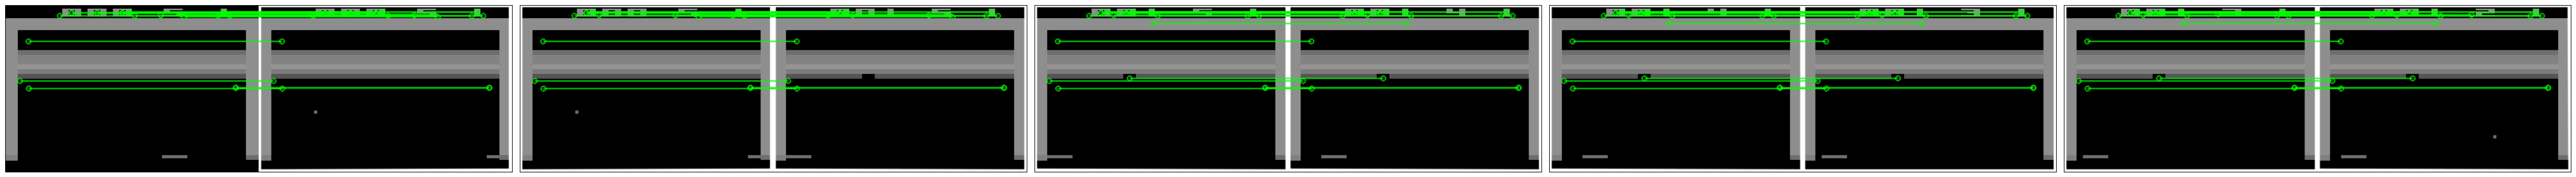

In [135]:
show_images(matched_images, mode='rgb')
#plt.imshow(cv.cvtColor(matched_images[1], cv.COLOR_BGR2RGB))

After having found some matches between frames we can identify connected components.
This can be done by thresholding the frames and the applying an algorithm to find the ccs.

In [136]:
thresholded = []
for i in gray_imgs: # see this again for better division of cc
    _, thresh = cv.threshold(i, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    thresholded.append(thresh)

num_labels = []
labels = []
stats = []
centroids = []
for t in thresholded:
    output = cv.connectedComponentsWithStats(t, 4, cv.CV_32S)
    num_labels.append(output[0])
    labels.append(output[1])
    stats.append(output[2])
    centroids.append(output[3])


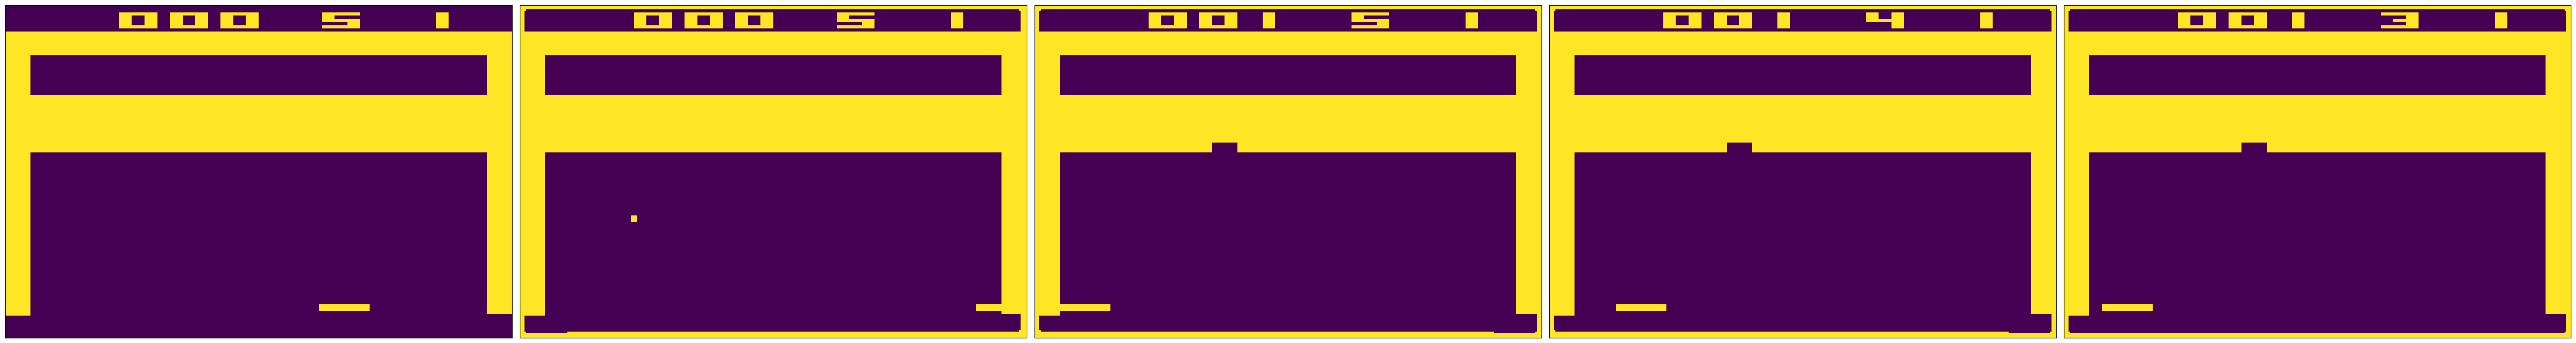

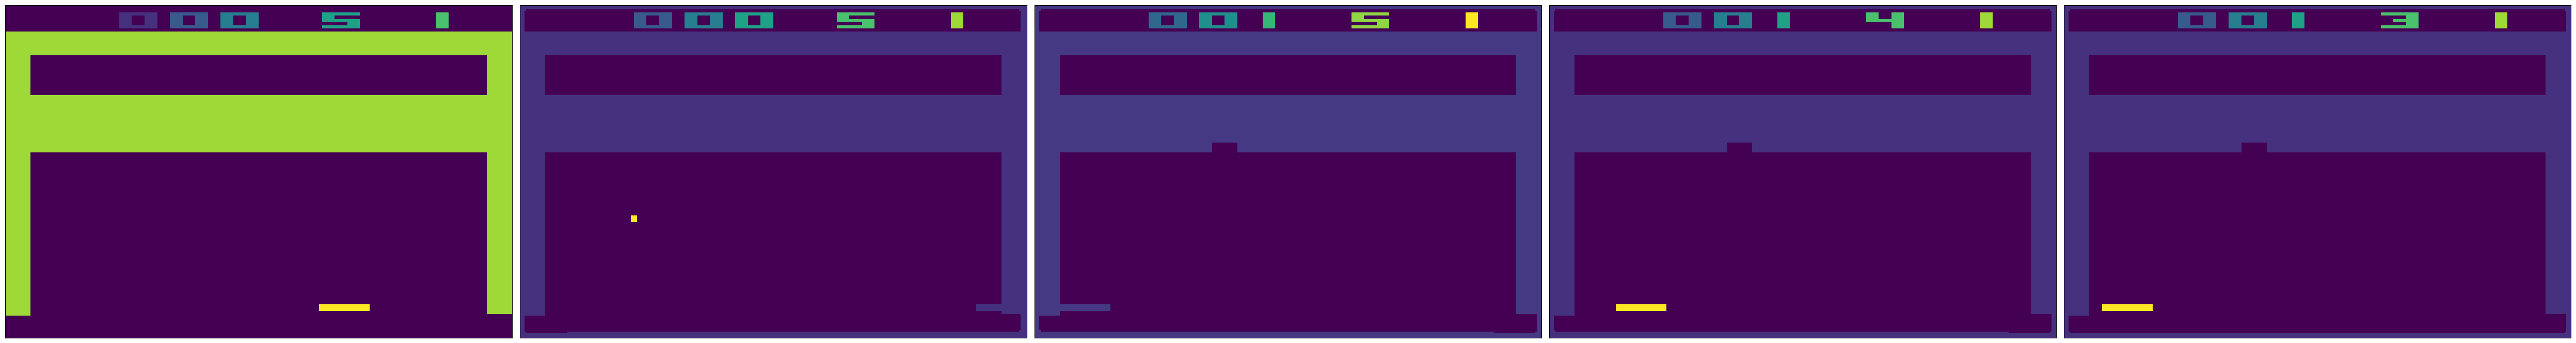

In [137]:
show_images(thresholded)    
show_images(labels)

#plt.imshow(thresholded[2])

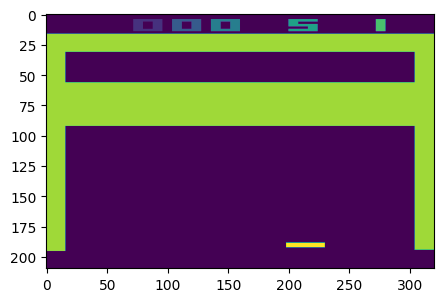

In [138]:
plt.imshow(labels[0])

In [139]:
def extract_pixel_lists(num_labels, labels):
    """"Function that from the labels output extract for every object in every frame the pixel list"""
    pixel_lists = []
    for i in range(len(num_labels)): # For every frame
        pixel_list = []
        for j in range(0, num_labels[i]): # For every object
            object_pixels = [] 
            for m in range(len(labels[i])):
                for n in range(len(labels[i][m])):
                    if labels[i][m][n] == j: # wrong check
                        object_pixels.append([m, n])
            pixel_list.append(object_pixels)
        pixel_lists.append(pixel_list)
    return pixel_lists


In [140]:
pixels_lists = extract_pixel_lists(num_labels, labels)

Now we have collected lost of data on the connected components in the frames.
We can see that some ccs are the background of the game.

In [141]:
# Let us write a function to remove some large backgrounds objects by checking if the area occupied
# is larger than a thershold value.

def removeLargeCCs(num_labels, stats, centroids, pixels_lists, max_area = 200):
    """"Function that clears our data from large objects in the images"""
    for i in range(len(num_labels)): # Iterate through frames
        to_del = []
        for j in range(num_labels[i]): # Iterate through objects
            if stats[i][j, cv.CC_STAT_AREA] > max_area:
                to_del.append(j)
        print(f"{i} to delete {to_del}")
        num_labels[i] = num_labels[i] - len(to_del)
        stats[i] = np.delete(stats[i], to_del, axis = 0)
        pixels_lists[i] = [ # Clear the pixel lists
            elem for idx, elem in enumerate(pixels_lists[i])
            if idx not in to_del
        ]
    return num_labels, stats, centroids, pixels_lists

num_labels, stats, centroids, pixels_lists = removeLargeCCs(num_labels, stats, centroids, pixels_lists)

0 to delete [0, 6]
1 to delete [0, 1]
2 to delete [0, 1]
3 to delete [0, 1]
4 to delete [0, 1]
5 to delete [0, 1]
6 to delete [0, 1]
7 to delete [0, 1]
8 to delete [0, 1]
9 to delete [0, 1]
10 to delete [0, 1]


In [142]:
for i in range(len(pixels_lists[0])):
    print(len(pixels_lists[0][i]))

192
192
192
176
80
128


In [143]:
# Iterating through to show info
for i in range(len(gray_imgs)): # Iterate through frames
    print(f"Frame #{i + 1}")
    for j in range(num_labels[i]):
        text = "examining component {}/{}".format( j + 1, num_labels[i])
        print("[INFO] {}".format(text))
        x = stats[i][j, cv.CC_STAT_LEFT]
        y = stats[i][j, cv.CC_STAT_TOP]
        w = stats[i][j, cv.CC_STAT_WIDTH]
        h = stats[i][j, cv.CC_STAT_HEIGHT]
        area = stats[i][j, cv.CC_STAT_AREA]
        (cX, cY) = centroids[i][j]
        print(x, y, w, h, area, cX, cY)


Frame #1
[INFO] examining component 1/6
72 5 24 10 192 159.55305410122165 120.2
[INFO] examining component 2/6
104 5 24 10 192 83.5 9.5
[INFO] examining component 3/6
136 5 24 10 192 115.5 9.5
[INFO] examining component 4/6
200 5 24 10 176 147.5 9.5
[INFO] examining component 5/6
272 5 8 10 80 211.5 9.5
[INFO] examining component 6/6
198 189 32 4 128 275.5 9.5
Frame #2
[INFO] examining component 1/6
72 5 24 10 192 159.35718062484196 120.52798914917584
[INFO] examining component 2/6
104 5 24 10 192 160.1359121340743 77.42952785192315
[INFO] examining component 3/6
136 5 24 10 192 83.5 9.5
[INFO] examining component 4/6
200 5 24 10 176 115.5 9.5
[INFO] examining component 5/6
272 5 8 10 80 147.5 9.5
[INFO] examining component 6/6
70 133 4 4 16 211.5 9.5
Frame #3
[INFO] examining component 1/5
72 5 24 10 192 160.04809541250802 120.06217379360865
[INFO] examining component 2/5
104 5 24 10 192 158.69393753290052 77.67871556413405
[INFO] examining component 3/5
144 5 8 10 80 83.5 9.5
[INFO] 

Observe that from frame #2 we have a new cc since the ball has been added to the game.
Also sometimes the bar is colliding with the left wall and we lose its location.
Let's see what the found cc are in the game:

#1 is the blue background that includes the numbers of the score.
#2
#3
#4
#8
#9

In [144]:
def draw_objects(imgs, stats):
    """"Function to draw rectangles around objects for better visualization"""
    # Let's now draw rectangles around cc
    drawn_cc = []
    for i in imgs:
        drawn_cc.append(i.copy())

    for i in range(len(drawn_cc)): # Iterate through frames
        for j in range(num_labels[i]):
            x = stats[i][j, cv.CC_STAT_LEFT]
            y = stats[i][j, cv.CC_STAT_TOP]
            w = stats[i][j, cv.CC_STAT_WIDTH]
            h = stats[i][j, cv.CC_STAT_HEIGHT]
            cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (0,255,0), 1)
    return drawn_cc

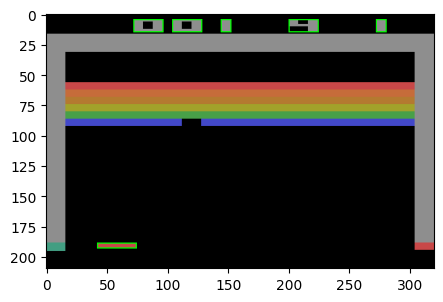

In [145]:
# Let's now draw rectangles around cc
drawn_cc = draw_objects(imgs, stats)
#show_images(drawn_cc, mode='rgb')
plt.imshow(cv.cvtColor(drawn_cc[3], cv.COLOR_BGR2RGB));

The current objective is now to define each cc as mobile or not and then track Its movements.

For classification get all pixels of an object in every frame and check if they are maintained in the next.


For tracking check centrometer of object to track movements.

In [146]:
centroids[0][0], stats[0][0, cv.CC_STAT_AREA]
# We need to retrieve information on pixels
np.max(labels[2])

np.int32(6)

In [147]:
# Classify objects as mobile or still

def find_intersection(p1, p2):
    """Function utility to perform intersection between pixel lists as we defined before"""
    temp_p1 = np.array(p1)
    temp_p2 = np.array(p2)
    _, ncols = np.array(temp_p1).shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [temp_p1.dtype]}
    inter = np.intersect1d(temp_p1.view(dtype), temp_p2.view(dtype))
    inter = inter.view(temp_p1.dtype).reshape(-1, ncols)
    return inter

def classify_objects(stats, pixels_lists, thresh = 0.90):
    """Function that classifies objects in every frame as static or mobile"""
    class_list = [] # Let us define 0 as static and 1 as mobile
    for i in range(len(stats) - 1): # Iterate on every frame
        frame_class = []
        for j in range(len(stats[i])): # Iterate on every object
            object_class = 1
            for n in range(len(stats[i + 1])): # Iterate on every object of successive frames
                inter = find_intersection(pixels_lists[i][j], pixels_lists[i + 1][n])
                area = stats[i][j, cv.CC_STAT_AREA]
                ratio = len(inter)/area
                if ratio >= thresh: # Check ratioo must be higher than a ratio
                    object_class = 0
            frame_class.append(object_class)
        class_list.append(frame_class)
    return class_list


In [148]:
classes = classify_objects(stats, pixels_lists, thresh=0.90)
len(classes[9])

6

In [149]:
def draw_classes(imgs, stats, classes):
    """"Function to draw rectangles around objects for better visualization"""
    # Let's now draw rectangles around cc
    drawn_cc = []
    for i in imgs[:len(imgs)-1]:
        drawn_cc.append(i.copy())

    for i in range(len(drawn_cc)): # Iterate through frames
        for j in range(num_labels[i]):
            x = stats[i][j, cv.CC_STAT_LEFT]
            y = stats[i][j, cv.CC_STAT_TOP]
            w = stats[i][j, cv.CC_STAT_WIDTH]
            h = stats[i][j, cv.CC_STAT_HEIGHT]
            if classes[i][j] == 0:
               cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (0,255,0), 1)
            else:
               cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (255,0,255), 1)
    print(i, j)
    return drawn_cc

9 5


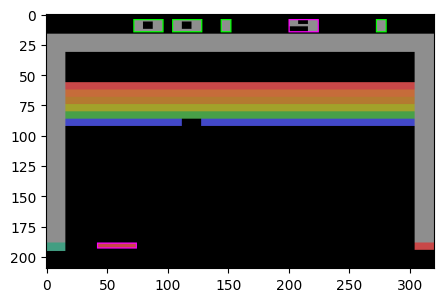

In [150]:
# Let's now draw rectangles around cc
drawn_cc = draw_classes(imgs, stats, classes)
#show_images(drawn_cc, mode='rgb')
plt.imshow(cv.cvtColor(drawn_cc[3], cv.COLOR_BGR2RGB));

In [151]:
mobile_obj = [] # Obtain the indexes of the mobile objects for easier access
for i in range(len(classes)):
    mobile_frame = []
    for j in range(len(classes[i])):
        if classes[i][j] == 1: 
            mobile_frame.append(j)
    mobile_obj.append(mobile_frame)
print(mobile_obj)

[[5], [2, 5], [3], [3, 5], [5], [2, 5, 6], [5, 6], [2, 5, 6], [3], [2, 5]]


In [152]:
def compute_dists(obj_pos):
    dist = 0
    partial_dist = [dist]
    for i in range(len(obj_pos) - 1):
        point1 = np.array(obj_pos[i + 1])
        point2 = np.array(obj_pos[i])
        delta_dist = np.linalg.norm(point1 - point2)
        dist = dist + delta_dist
        partial_dist.append(dist)
    return partial_dist



def track_objects(stats, mobile_obj, thresh = 0):
    """Function that tracks the distance of visible mobile objects through frames, 
    keeping in mind we cannot use the last frame since the classes stop at the last frame"""
    tracked = [] # Initalize a bool array to keep track of mobile objects in frames
    apparitions = [] # Find and match the same object through frames
    for i in range(len(mobile_obj)): # Iterate through frames - 1
        tracked.append(np.full(len(mobile_obj[i]), False))

    for i in range(len(mobile_obj)): # Iterate through frames - 1
        for j in range(len(mobile_obj[i])): # Iterate through mobile objects
            apparition = []
            #print(tracked)
            if not tracked[i][j]: # If the current object is not already tracked
                apparition.append((i, mobile_obj[i][j]))
                #print(f"Frame {i}, object {mobile_obj[i][j]} {tracked[i][j]}")
                # Check for the object in the other frames
                area = stats[i][mobile_obj[i][j], cv.CC_STAT_AREA]
                for k in range(i + 1, len(mobile_obj)): # Go to next frame to search for same obj
                    for n in range(len(mobile_obj[k])): # Iterate throuh mobile objects of next frame
                        if not tracked[k][n]:
                            area_next = stats[k][mobile_obj[k][n], cv.CC_STAT_AREA]
                            # Here we must find an object similiar to our starting one in order to track it
                            if area == area_next - thresh:
                                # Here we could also add a check on the distance of the object for the matching
                                #print(f"Found successor of {i, mobile_obj[i][j]} in object {k, mobile_obj[k][n]}")
                                apparition.append((k, mobile_obj[k][n]))
                                tracked[k][n] = True
                tracked[i][j] = True
            if len(apparition) > 0: 
                apparitions.append(apparition)
    
    # Now we must find the controids for every object and then compute distances at various frames
    app_coord = []
    for i in range(len(apparitions)): # Iterate on every mobile object
        obj_cord = []
        obj_frame = []
        for j in range(len(apparitions[i])): # Iterate on every apparition of that object
            #print(apparitions[i][j])
            frame, obj = apparitions[i][j]
            x = stats[frame][obj, cv.CC_STAT_LEFT] + (stats[frame][obj, cv.CC_STAT_WIDTH]/2)
            y = stats[frame][obj, cv.CC_STAT_TOP] - (stats[frame][obj, cv.CC_STAT_HEIGHT]/2)
            obj_cord.append((x, y))
        app_coord.append(obj_cord)

        partial_dist = []
        for a in app_coord:
            partial_dist.append(compute_dists(a))
        
        app_frame = []
        for app in apparitions:
            obj_frame = []
            for a in app:
                frame, _ = a
                obj_frame.append(frame)
            app_frame.append(obj_frame)
        
        distance = {"partial_dist" : partial_dist, "frame": app_frame}
    return distance

In [153]:
tracking = track_objects(stats, mobile_obj)

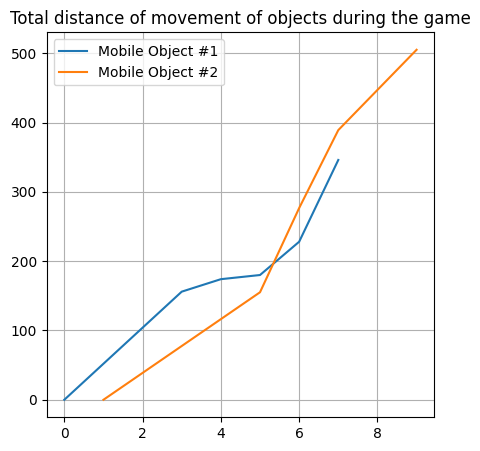

In [155]:
fig, ax = plt.subplots(figsize= (5, 5))
count = 1
for i in range(len(tracking['frame'])):
    if len(tracking['frame'][i]) > 4:
        ax.plot(tracking['frame'][i], tracking['partial_dist'][i], label=f'Mobile Object #{count}')
        count = count + 1
ax.set_title("Total distance of movement of objects during the game")
ax.legend()
ax.grid(True)
